In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing 
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve, train_test_split
from scipy.stats import bernoulli,norm
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss
import time
from sklearn.metrics import accuracy_score

# Preparation

### load dataset and separate X and t

In [2]:
data = pd.read_csv('data.csv')
data.head()
#remove something useless
data = data.drop(['id','Unnamed: 32'],axis=1)
data.diagnosis.replace(to_replace = dict(M = 1, B = 0), inplace = True)
#seepate X and t
X = data.drop('diagnosis',axis=1)
t = data.diagnosis

In [3]:
#X = data[['concavity_mean','concave points_mean','concavity_worst','area_worst','concave points_worst']]

In [4]:
# normalize X, let it in the range(0,1)
X = preprocessing.normalize(X, axis=0)

#take a look
X_pd = pd.DataFrame(X)
X_pd.head()
X.shape

(569, 30)

### split training and testing set(80%,20%)

In [5]:
# Train_test split
# total 569 data, 455 for training
random_state = 42
X_train, X_test, y_train, y_test = train_test_split(X, t, test_size = 0.2, random_state = random_state)

In [6]:
X_train.shape

(455, 30)

In [7]:
#Take a look
len(X_train[:,1])
np.shape(X_train)
np.shape( y_train)

(455,)

# Model

### global func

In [8]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [9]:
# likelihood function
def likelihood(w,X):
    condition = sigmoid(np.matmul(X,w))
    result = bernoulli.rvs(condition)
    return result

### MLE(inference+prediction)

#### First order method. GD & mini_batch GD & SGD(mini_batch size =1) 

In [33]:
error_recorder_First_GD_MLE = []
def First_GD_MLE(X, init_w, t, iter_time, epsilon, signal, method, batch_size=0):
    # formula: w_new = w - epsolon * gradient(w_old)
    # dimensional check: w: 30*1, X: 459*30, t:459*1, Grad_w: 30*1, final_w: 30*1
    # if convergence, return w_new, otherwise return 0
    final_w = 0 # to judge convergence
    if(method == 'GD'):
        for i in range(iter_time):
            sigmoid_term = sigmoid(np.matmul(X,init_w))-t
            gradient_w = np.matmul(np.transpose(X),sigmoid_term)
            w_new = init_w - epsilon * gradient_w 
            #error = np.linalg.norm(w_new - init_w)
            error = log_loss(likelihood(w_new,X),y_train)
            error_recorder_First_GD_MLE.append(error)
            if(error < signal): #convergence
                final_w = w_new
                break
            else:
                init_w = w_new
    #some bugs
    elif(method == 'Mini_batch'):
        for i in range(iter_time):
            idx = np.random.randint(np.shape(X)[0],size=batch_size)
            X_s = X[idx,:]
            t_s = t.take(idx)
            sigmoid_term = sigmoid(np.matmul(X_s,init_w))- np.array(t_s)
            gradient_w = np.matmul(np.transpose(X_s),sigmoid_term)
            w_new = init_w - epsilon * gradient_w
            #error = np.linalg.norm(w_new - init_w)
            error = log_loss(t,likelihood(w_new,X))
            error_recorder_First_GD_MLE.append(error)
            if(error < signal): #convergence
                final_w = w_new
                break
            else:
                init_w = w_new
            # check if convergence each 1000 itertion         
    return final_w

### Prediction

#### use First order MLE

In [11]:
# accuracy function
def accuracy(a,b):
    # formula : same number/all number
    all_number = np.shape(a)[0]
    same_number = 0
    for i in range(all_number):
        if(a[i]==b[i]):
            same_number+=1
    return same_number/all_number

In [22]:
# prediction by first order MLE(Gradient descent)

X = X_train
t = y_train
init_w = np.ones(30)
iter_time = 50000
signal = 2
epsilon = 0.01
time_start=time.time()
w = First_GD_MLE(X, init_w, t, iter_time, epsilon, signal, method='GD')
time_end=time.time()
print('time cost',time_end-time_start,'s')

time cost 20.60502004623413 s


In [34]:
# sgd
X = X_train
t = y_train
#init_w = np.random.rand(30)
init_w = np.ones(30)
iter_time = 30000
signal = 2
epsilon = 0.2
time_start=time.time()
w = First_GD_MLE(X, init_w, t, iter_time, epsilon, signal, method='Mini_batch',batch_size = 30)
time_end=time.time()
print('time cost',time_end-time_start,'s')

time cost 9.727652311325073 s


In [35]:
print(error_recorder_First_GD_MLE[-10:])
print(len(error_recorder_First_GD_MLE))

[3.8714215087445485, 4.782344836928086, 4.023238548727826, 3.7955244115733415, 3.4159651167237484, 4.402803115648388, 4.175064375496051, 3.871430295529496, 3.3400574754106045, 1.9736636963503522]
9976


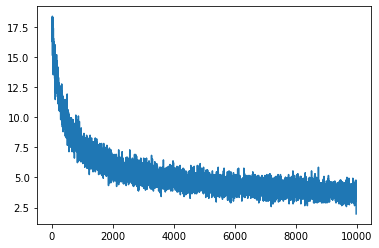

In [37]:
x = np.arange(9976)
y = error_recorder_First_GD_MLE
plt.plot(x,y)

In [17]:
# training accurancy(0.9538461538461539)
y_predict = likelihood(w,X)
print('training accuracy:',accuracy_score(y_predict,y_train.values))

# prediction accuracy (0.9261403508771928)
test_acc=[]

for i in range(1000):
    y_predict = likelihood(w,X_test)
    #print('testing accuracy:',accuracy_score(y_predict,y_test.values))
    test_acc.append(accuracy_score(y_predict,y_test.values))
np.mean(test_acc)

training accuracy: 0.8923076923076924


0.9156228070175438

### PPE(by Laplace approximation)

In [12]:
error_recorder_First_GD_MAP = []

def First_GD_MAP(X, init_w, t, iter_time, epsilon, signal, alpha, method, batch_size=0):
    # formula: w_new = w - epsolon * gradient(w_old)
    # dimensional check: w: 30*1, X: 459*30, t:459*1, Grad_w: 30*1, final_w: 30*1, alpha: scaler
    # if convergence, return w_new, otherwise return 0
    final_w = 0 # to judge convergence
    if(method == 'GD'):
        for i in range(iter_time):
            sigmoid_term = sigmoid(np.matmul(X,init_w))-t
            gradient_w = np.matmul(np.transpose(X),sigmoid_term)+ alpha*init_w
            w_new = init_w - epsilon * gradient_w 
            error = np.linalg.norm(w_new - init_w)
            #error = log_loss(likelihood(w_new,X),likelihood(init_w,X))
            error_recorder_First_GD_MAP.append(error)
            if(error < signal): #convergence
                final_w = w_new
                break
            else:
                init_w = w_new
    elif(method == 'Mini_batch'):
        for i in range(iter_time):
            idx = np.random.randint(np.shape(X)[0],size=batch_size)
            X_s = X[idx,:]
            t_s = t.take(idx)
            sigmoid_term = sigmoid(np.matmul(X_s,init_w))-t_s
            gradient_w = np.matmul(np.transpose(X_s),sigmoid_term)
            w_new = init_w - epsilon * gradient_w
            error = log_loss(likelihood(w_new,X),likelihood(init_w,X))
            error_recorder_First_GD_MAP.append(error)
            init_w = w_new
            # check if convergence each 1000 itertion
            if(error < signal): #convergence
                final_w = w_new
                break        
    return final_w

In [13]:
def variance_for_laplace(X,w,alpha):
    # hessian: X^T*R(w)X + alpha * I_D
    # r_n(w) = sigmoid(x_n*w)(1-sigmoid(x_n*w))
    # dimension: X:459*30, R(w):459*459, X_n:1*30, w:30*1 hessian: 30*30
    
    # compute r_n(w)
    temp = [] #temporary room for r_nw
    for i in range(X.shape[0]):
        r_nw = sigmoid(np.matmul(X[i,:],w)) * (1-sigmoid(np.matmul(X[i,:],w)))
        temp.append(r_nw)
    
    # make r_n(w) a matrix -> R(W)
    R_w = np.diag(temp) # shape: 459*459
    
    # diagonal alpha (alpha * I_D)
    alpha_tmp = np.ones(X.shape[1]) * alpha
    diag_alpha = np.diag(alpha_tmp)
    
    #Hessian matrix
    hessian = np.matmul(np.matmul(np.transpose(X),R_w),X) + diag_alpha
    
    return hessian

In [14]:
# use Monte Carlo to compute PPE
# w is sampled from N(w_map,hessian)

def PPE_MC(X,mean,variance,iter_time_ppe):
    w_sampling_sum = np.zeros(30)
    for i in range(iter_time):
        #w_sampling = np.random.multivariate_normal(mean=w_map, cov=np.linalg.inv(hessian)) 
        w_sampling = np.random.multivariate_normal(mean=w_map, cov=hessian) 
        w_sampling_sum += w_sampling
    w_sampling = w_sampling_sum/iter_time
    prediction = likelihood(w_sampling,X)
    return prediction

In [15]:
X = X_train
t = y_train
init_w = np.random.rand(30)
iter_time = 50000
signal = 0.001
epsilon = 0.01
alpha = 0.001   #0.001

w_map = First_GD_MAP(X, init_w, t, iter_time, epsilon, signal, alpha,method='GD')
hessian = variance_for_laplace(X,w_map,alpha)

In [16]:
print(error_recorder_First_GD_MAP[-1])
print(len(error_recorder_First_GD_MAP))

0.0009999785359260326
45764


In [18]:
iter_time_ppe = 10000
prediction_train = PPE_MC(X,w_map,hessian,iter_time_ppe)
print('training accuracy:',accuracy_score(prediction_train,y_train.values))

training accuracy: 0.8967032967032967


In [19]:
prediction_test = PPE_MC(X_test,w_map,hessian,iter_time_ppe)
print(accuracy_score(prediction_test,y_test.values))



for i in range(100):
    prediction_test = PPE_MC(X_test,w_map,hessian,iter_time_ppe)
    #print('testing accuracy:',accuracy_score(y_predict,y_test.values))
    test_acc.append(accuracy_score(prediction_test,y_test.values))
np.mean(test_acc)



0.9473684210526315


"\nfor i in range(100):\n    prediction_test = PPE_MC(X_test,w_map,hessian,iter_time_ppe)\n    #print('testing accuracy:',accuracy_score(y_predict,y_test.values))\n    test_acc.append(accuracy_score(prediction_test,y_test.values))\nnp.mean(test_acc)\n"

assumption:  

1 and 2. We hypothesize that some features are insignificant to our classification task. As we discuss in data analysis part, these features should be highly correlated or the mean of Gaussian distribution is almost same. To verify, we bin the features which are highly correlated/same Gaussian mean(two different hypotheses) into a bin and compute the classification accuracy by only using the features in this bin. Then we removed a feature in this bin and compute the classification accuracy again. Repeat above process for several times. If the classification accuracy is unchanged, we can verify our hypothesis.  


3. We hypothesize that the running time of SGD is the fastest. Since compared to gradient descent, it doesn't need to compute the gradient of the whole dataset in each iteration. Besides, the running time between first order gradient descent and second order gradient descent is waiting to verify. Since the complexity of 1st is $O(M)$ for each iteration, while the 2rd needs $O(M^{3})$. However, the 2rd uses fewer iterations for convergence.  


4. We hypothesize that MAP will outperform MLE on negative log-likelihood. Since our dataset only have 569 data, which is not big enough.

## Assumption1

In [ ]:
# remove the highly correlated features
X_copy = X_pd.copy()
t_copy = t.copy()

In [ ]:
correlated_features = set()
correlation_matrix = X_copy.corr() # correlation matrix
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        #threshold = 0.9
        if abs(correlation_matrix.iloc[i, j]) > 0.80: 
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)
print(len(correlated_features))
print(correlated_features)

In [ ]:
X_copy.drop(labels=correlated_features,axis=1,inplace=True)

In [ ]:
X_copy.shape

In [ ]:
#split training and testing set
X_train, X_test, y_train, y_test = train_test_split(X_copy, t, test_size = 0.2, random_state = 42)

In [ ]:
# use first order mle to make prediction
X = X_train
t= y_train
init_w = np.random.rand(25)
iter_time = 50000
signal = 0.0025
epsilon = 0.01
time_start=time.time()
w = First_GD_MLE(X, init_w, t, iter_time, epsilon, signal, method='GD')
time_end=time.time()
print('time cost',time_end-time_start,'s')

In [ ]:
error_recorder_First_GD_MLE[-10:]

In [ ]:
x = np.arange(0,38900)
y = error_recorder_First_GD_MLE
plt.plot(x,y)

In [ ]:
y_predict = likelihood(w,X)
print('training accuracy:',accuracy_score(y_predict,y_train.values))

# prediction accuracy (0.8982456140350876)
test_acc=[]

for i in range(100):
    y_predict = likelihood(w,X_test)
    #print('testing accuracy:',accuracy_score(y_predict,y_test.values))
    test_acc.append(accuracy_score(y_predict,y_test.values))
np.mean(test_acc)

In [ ]:
# pca
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
X_pca = X.copy()
pca.fit_transform(X_pca)

#### delete w=0 data

In [ ]:
#[7,8,24,27,28]
X_copy = X_copy.drop([], axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_copy, t, test_size = 0.2, random_state = 42)

In [ ]:
# use first order mle to make prediction
X = X_train
t= y_train
init_w = np.random.rand(25)
iter_time = 50000
signal = 0.0025
epsilon = 0.01
time_start=time.time()
w = First_GD_MLE(X, init_w, t, iter_time, epsilon, signal, method='GD')
time_end=time.time()
print('time cost',time_end-time_start,'s')

In [ ]:
error_recorder_First_GD_MLE[-10:]

In [ ]:
y_predict = likelihood(w,X)
print('training accuracy:',accuracy_score(y_predict,y_train.values))

# prediction accuracy (0.8982456140350876)
test_acc=[]

for i in range(100):
    y_predict = likelihood(w,X_test)
    #print('testing accuracy:',accuracy_score(y_predict,y_test.values))
    test_acc.append(accuracy_score(y_predict,y_test.values))
np.mean(test_acc)

#### pca by mle

In [ ]:
X = X_pca
t = y_train
init_w = np.random.rand(30)
iter_time = 50000
signal = 0.002
epsilon = 0.01
time_start=time.time()
w = First_GD_MLE(X, init_w, t, iter_time, epsilon, signal, method='GD')
time_end=time.time()
print('time cost',time_end-time_start,'s')

In [ ]:
# mle for pca
# training accurancy(0.9538461538461539)
y_predict = likelihood(w,X_pca)
print('training accuracy:',accuracy_score(y_predict,y_train.values))

# prediction accuracy (0.9261403508771928)
test_acc=[]

for i in range(100):
    y_predict = likelihood(w,X_test)
    #print('testing accuracy:',accuracy_score(y_predict,y_test.values))
    test_acc.append(accuracy_score(y_predict,y_test.values))
np.mean(test_acc)

#### PCA by map

In [ ]:
X =  X_pca
t = y_train
init_w = np.random.rand(30)
iter_time = 50000
signal = 0.001
epsilon = 0.01
alpha = 0.001   #0.001

w_map = First_GD_MAP(X, init_w, t, iter_time, epsilon, signal, alpha,method='GD')
hessian = variance_for_laplace(X,w_map,alpha)

In [ ]:
iter_time_ppe = 10000
prediction_train = PPE_MC(X,w_map,hessian,iter_time_ppe)
print('training accuracy:',accuracy(prediction_train,y_train.values))

In [ ]:
test_acc=[]
for i in range(10):
    prediction_test = PPE_MC(X_test,w_map,hessian,iter_time_ppe)
    #print('testing accuracy:',accuracy_score(y_predict,y_test.values))
    test_acc.append(accuracy_score(prediction_test,y_test.values))
np.mean(test_acc)


## Assumption2

## Assumption3